# Tweets Language Classification

## Author: Luis Eduardo Ferro Diez <a href="mailto:luis.ferro1@correo.icesi.edu.co">luis.ferro1@correo.icesi.edu.co</a>

This notebook contains the model training preparation for classifying the tweets language.

## Dataset
* Tweets dataset in parquet format (After executing the first transformation spark pipeline)

## Resources
* https://machinelearningmastery.com/best-practices-document-classification-deep-learning/

## Objective
A large number of tweets lack of language identification which is needed in later stages of the project when trying to classify tweets as spam or ham, and furthemore, for simplicity the intention is only to consider english tweets for the analysis of where to sell products geographically speaking.

Depending on the tweet year collection, an important number of tweets does not have language tag, or Twitter itself was not able to identify the language and tagged the `lang` value as `und` for `undefined`. The objective in this notebook is to model two deep learning pipelines with keras to classify if a tweet is either written in english or not. We are not interested for now in the other languages hence we can deem this as a binary classification problem.

### Prepare the data

In [1]:
tweets_path = "../../datasets/tweets_parquet"

In [2]:
import pandas as pd

tweets = pd.read_parquet(tweets_path, engine="pyarrow")

In [3]:
tweets.head()

,id,tweet,lang,favorite_count,retweet_count,is_retweet,user_id,user_name,user_followers_count,user_following_count,...,place_full_name,country,country_code,place_type,place_url,is_spam,year,month,day,hour
0,374048987046637568,@fizziero ngareb beud! !,id,0.0,0.0,0.0,389276837,syarifsidi,47.0,63.0,...,"Jatinegara, Jakarta Timur",Indonesia,ID,city,https://api.twitter.com/1.1/geo/id/9e0e6d510fb...,0.0,2013,9,1,1
1,374048987046625280,"@shahshahrul11 nak buat acano,keto den lg pent...",id,0.0,0.0,0.0,184869610,AliffSadali,194.0,247.0,...,"Keratong, Rompin",Malaysia,MY,city,https://api.twitter.com/1.1/geo/id/1deede127b2...,0.0,2013,9,1,1
2,374048987034419200,@adambeyer234: I already miss Jace like hell,en,0.0,0.0,0.0,363516745,rilez_sharp,582.0,666.0,...,"New York, US",United States,US,admin,https://api.twitter.com/1.1/geo/id/94965b2c453...,0.0,2013,9,1,1
3,374048987050823680,"""this is us""...nunca me voy a artar de verla.....",es,0.0,0.0,0.0,446125189,LUCRECIALg,13.0,65.0,...,Argentina,Argentina,AR,country,https://api.twitter.com/1.1/geo/id/4d3b316fe2e...,0.0,2013,9,1,1
4,374048991241310208,Aquí en una reunión casual (@ Dhamy's Bar) [pi...,es,0.0,0.0,0.0,44793849,charal3x,66.0,77.0,...,"Veracruz, Veracruz de Ignacio de la Llave",México,MX,city,https://api.twitter.com/1.1/geo/id/6c67fe933a6...,0.0,2013,9,1,1


We consider the most relevant parts to predict the tweet language to be:
* The tweet text
* The country code

The tweet text might contain user mentions, for simplicity, we will first transform the text, replacing the user mention with the text "@usermention".

Since we are only interested in detecting if a tweet is written in english or not, we would need to transform the `lang` column into a numberic value with `lang=1` for the possitive class, i.e., "The tweet is in english" and `lang=0` for the negative class, i.e., "The tweet is not written in english language."

In [5]:
import re

tweets.tweet = tweets.tweet.apply(lambda x: re.sub(r"@[\w\d]+", "@usermention", x))
tweets = tweets[["tweet", "country_code", "lang"]]
tweets.lang = tweets.lang.apply(lambda x: 1.0 if x == 'en' else 0.0)
tweets.head()

,tweet,country_code,lang
0,@usermention ngareb beud! !,ID,0.0
1,"@usermention nak buat acano,keto den lg pentin...",MY,0.0
2,@usermention: I already miss Jace like hell,US,1.0
3,"""this is us""...nunca me voy a artar de verla.....",AR,0.0
4,Aquí en una reunión casual (@ Dhamy's Bar) [pi...,MX,0.0


Now let's convert the country code into a onehot encoding

In [6]:
tweets.country_code.unique()

array(['ID', 'MY', 'US', 'AR', 'MX', 'GB', 'RU', 'CL', 'JP', 'BR', 'CA',
       'TR', 'PH', 'FR', 'IT', 'NL', 'ES', 'DE', 'NO', 'ZA'], dtype=object)

In [7]:
from sklearn.preprocessing import LabelEncoder

country_encoder = LabelEncoder()
country_encoded = country_encoder.fit_transform(tweets.country_code.values).reshape(-1, 1)

## Baseline

In order to assess if the models are good or not, we'll need to establish a baseline. Since this is a classification problem, and there is no previous reference, our baseline is the most predominant class.

In [8]:
tweets.lang.value_counts()

0.0    99
1.0    87
Name: lang, dtype: int64

We can see the majority of tweets are NOT written in english language. Now let's define the baseline

In [10]:
en = tweets.lang.value_counts()[0]
total = tweets.lang.count()
baseline = en / total
print(f"The baseline is: {baseline:.2f}")

The baseline is: 0.53


With "not english" as the predominat class, we have a prediction power of $53\%$. This is what we will try to improve with the models.

With this information we'll create embeddings to train a CNN + Fully Connected ANN to predict the language.

Also for testing, we are going to use a LTSM + Fully Connected ANN and compare the results.

Since we are dealing with two types of features, we'll need to prepare a bidirectional NN

## Tweet Embeddings

First, we'll need to create the embedding representation of the tweet corpus. There are a couple of caveats we must consider:
* A tweet might contain urls, this makes necessary to parse or mask them so they get not separated when tokenizing the text.

In [12]:
test = "hey"
test.replace()

In [15]:
from urlextract import URLExtract

def replace_url(string, replacement=''):
    url_extract = URLExtract()
    urls = url_extract.find_urls(string)
    for url in urls:
        string = string.replace(url, replacement)
    return string

test = "This is a similated tweet with a url at https://somedomain.com, plus another one at http://www.google.com"
print(f"Replacing with default value: {replace_url(test)}")
print(f"Replacing with cusom value: {replace_url(test, 'some_url')}")

Replacing with default value: This is a similated tweet with a url at , plus another one at 
Replacing with cusom value: This is a similated tweet with a url at some_url, plus another one at some_url


In [16]:
tweets.tweet = tweets.tweet.apply(lambda t: replace_url(t, "<url>"))
tweets.head()

,tweet,country_code,lang
0,@usermention ngareb beud! !,ID,0.0
1,"@usermention nak buat acano,keto den lg pentin...",MY,0.0
2,@usermention: I already miss Jace like hell,US,1.0
3,"""this is us""...nunca me voy a artar de verla.....",AR,0.0
4,Aquí en una reunión casual (@ Dhamy's Bar) [pi...,MX,0.0


In [17]:
from keras.preprocessing.text import Tokenizer

words = 1000
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(tweets.tweet)
print(f"Unique tokens: {len(tokenizer.word_index)}")
first10 = {k:tokenizer.word_index[k] for k in list(tokenizer.word_index)[:10]}
print(f"The first 10 items in the word index are: {first10}")

Unique tokens: 942
The first 10 items in the word index are: {'usermention': 1, 'url': 2, 'i': 3, 'to': 4, 'the': 5, 'a': 6, 'at': 7, 'me': 8, 'you': 9, 'and': 10}


In [18]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

MAX_TEXT_SEQ_LEN = 280
tweet_sequences = np.array(tokenizer.texts_to_sequences(tweets.tweet))
tweet_sequences = pad_sequences(tweet_sequences, MAX_TEXT_SEQ_LEN)

`tweet_sequences` contains the indexed text strings which are going to be the input for the NN.

Now, let's assemble everything and prepare the train and test sets.

In [20]:
from sklearn.model_selection import train_test_split

X = tweet_sequences
X_c = country_encoded
y = tweets.lang.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train_c, X_test_c, _, _ = train_test_split(X_c, y, test_size=0.2, random_state=1234)

Now, let's define the models

## LSTM based model

First, we will train a LSTM based model with the embeddings of each tweet, and make predictions for the tweet language.

In [28]:
from keras.layers import Input, Embedding, Bidirectional, Dense, LSTM, concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras import regularizers

#Define the inputs
tweet_input = Input(shape=(MAX_TEXT_SEQ_LEN,), dtype='int32', name='tweet_text')
country_input = Input(shape=(1,), name='country_input')

#Define the embedding layer consuming the tweet input
emb = Embedding(input_dim=tokenizer.num_words, output_dim=64, input_length=MAX_TEXT_SEQ_LEN)(tweet_input)

#Define the LSTM layer with the embedding input
tweet_output = Bidirectional(
        LSTM(units=30, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01))
    )(emb)

#Define an auxiliary output for the first input
aux_output = Dense(1, activation='sigmoid', name='aux_output')(tweet_output)

#Concatenate the LSTM output with the country input
x = concatenate([tweet_output, country_input])

#Apply a dense layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(25, activation='relu')(x)

#And finally make the predictions using the previous layer as input
main_output = Dense(1, activation='sigmoid', name='prediction')(x)

model = Model(inputs=[tweet_input, country_input], outputs=[main_output, aux_output])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tweet_text (InputLayer)         (None, 280)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 280, 64)      64000       tweet_text[0][0]                 
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 60)           22800       embedding_4[0][0]                
__________________________________________________________________________________________________
country_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
concatenat

In [32]:
%%time
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

train_data = [X_train, X_train_c]
history = model.fit(train_data, [y_train] * 2, epochs = 100, batch_size = 20, validation_split= 0.2, callbacks=[early_stopping])

Train on 118 samples, validate on 30 samples
Epoch 1/100
118/118 [==============================] - 4s 35ms/step - loss: 0.2068 - prediction_loss: 0.0319 - aux_output_loss: 0.0816 - prediction_acc: 1.0000 - aux_output_acc: 1.0000 - val_loss: 0.8480 - val_prediction_loss: 0.3736 - val_aux_output_loss: 0.3814 - val_prediction_acc: 0.8667 - val_aux_output_acc: 0.9000
Epoch 2/100
118/118 [==============================] - 4s 34ms/step - loss: 0.1869 - prediction_loss: 0.0212 - aux_output_loss: 0.0731 - prediction_acc: 1.0000 - aux_output_acc: 1.0000 - val_loss: 0.8210 - val_prediction_loss: 0.3433 - val_aux_output_loss: 0.3857 - val_prediction_acc: 0.8667 - val_aux_output_acc: 0.9000
Epoch 3/100
118/118 [==============================] - 4s 33ms/step - loss: 0.1784 - prediction_loss: 0.0187 - aux_output_loss: 0.0680 - prediction_acc: 1.0000 - aux_output_acc: 1.0000 - val_loss: 0.8107 - val_prediction_loss: 0.3316 - val_aux_output_loss: 0.3881 - val_prediction_acc: 0.9000 - val_aux_output_a

In [30]:
import matplotlib.pyplot as plt

def plot_history(cnn, acc= 'acc', val_acc = 'val_acc', loss = 'loss', val_loss = 'val_loss'):
    fig = plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    plt.title('Accuracy in training Vs validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.plot(cnn.history[acc], 'r')
    plt.plot(cnn.history[val_acc], 'b')
    plt.legend(['training', 'validation'])
    
    plt.subplot(1, 2, 2)
    plt.title('Loss in training Vs validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(cnn.history[loss], 'r')
    plt.plot(cnn.history[val_loss], 'b')
    plt.legend(['training', 'validation'])
    
    plt.show()
    

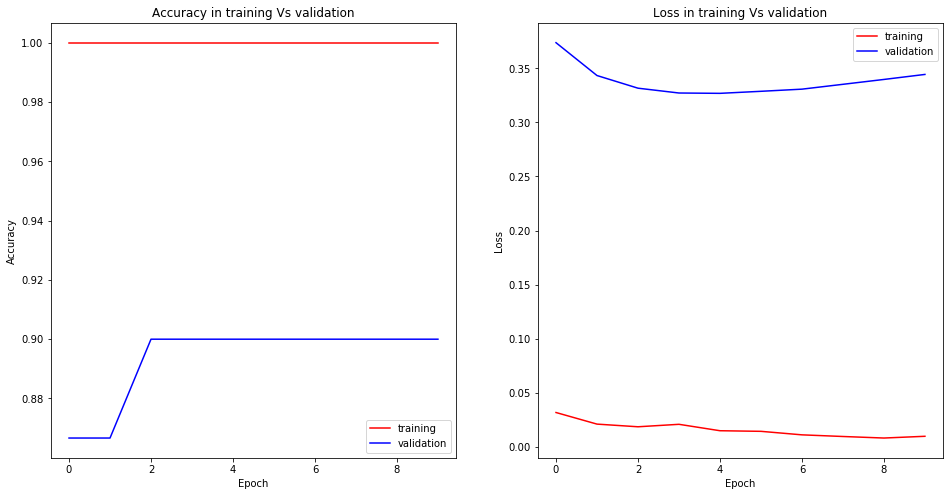

In [33]:
plot_history(history, 
             acc='prediction_acc', 
             val_acc='val_prediction_acc', 
             loss='prediction_loss', 
             val_loss='val_prediction_loss')

In [46]:
test_prediction = model.predict([X_test, X_test_c])
y_pred = np.where(test_prediction[0]>0.5, 1.0, 0.0)

In [53]:
from sklearn.metrics import accuracy_score

test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.2f}")

Test accuracy: 0.87


With this sample and tiny model we got $87\%$ of accuracy score within the testing set which is acceptable considering our initial baseline of $53\%$

## CNN Based model
Now let's design a model using Convolutional Neural Networks with the same embeddings and see how it performs against our LSTM based model.

In [55]:
from keras.layers import Input, Embedding, Bidirectional, Dense, Conv1D, Flatten, MaxPool1D, concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras import regularizers

#Define the inputs
tweet_input = Input(shape=(MAX_TEXT_SEQ_LEN,), dtype='int32', name='tweet_text')
country_input = Input(shape=(1,), name='country_input')

#Define the embedding layer consuming the tweet input
emb = Embedding(input_dim=tokenizer.num_words, 
                output_dim=64, 
                input_length=MAX_TEXT_SEQ_LEN)(tweet_input)

#Define the convolutional layers consuming the tweet input
conv = Conv1D(32, 3, activation='relu', input_shape=(64,))(emb)
conv = MaxPool1D(2, strides=None, padding='valid')(conv)
conv = Conv1D(128, 3, activation='relu')(conv)
conv = MaxPool1D(2, strides=None, padding='valid')(conv)
conv = Conv1D(128, 3, activation='relu')(conv)
conv = MaxPool1D(2, strides=None, padding='valid')(conv)
conv_output = Flatten()(conv)

#Define an auxiliary output for the first input
aux_output = Dense(1, activation='sigmoid', name='aux_output')(conv_output)

#Concatenate the convolutional output with the country input
x = concatenate([conv_output, country_input])

#Apply a dense layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(25, activation='relu')(x)

#And finally make the predictions using the previous layer as input
main_output = Dense(1, activation='sigmoid', name='prediction')(x)

model = Model(inputs=[tweet_input, country_input], outputs=[main_output, aux_output])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

W0729 16:08:16.214473 139714601400128 deprecation_wrapper.py:119] From /home/ohtar10-kudu/miniconda3/envs/wtsp/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tweet_text (InputLayer)         (None, 280)          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 280, 64)      64000       tweet_text[0][0]                 
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 278, 32)      6176        embedding_6[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 139, 32)      0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (

In [74]:
%%time
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

train_data = [X_train, X_train_c]
history = model.fit(train_data, [y_train] * 2, epochs = 100, batch_size = 20, validation_split= 0.2, callbacks=[early_stopping])

Train on 118 samples, validate on 30 samples
Epoch 1/100
118/118 [==============================] - 0s 2ms/step - loss: 0.1794 - prediction_loss: 0.0954 - aux_output_loss: 0.0840 - prediction_acc: 0.9492 - aux_output_acc: 0.9576 - val_loss: 0.8835 - val_prediction_loss: 0.4599 - val_aux_output_loss: 0.4236 - val_prediction_acc: 0.9333 - val_aux_output_acc: 0.9000
Epoch 2/100
118/118 [==============================] - 0s 2ms/step - loss: 0.1666 - prediction_loss: 0.0830 - aux_output_loss: 0.0836 - prediction_acc: 0.9661 - aux_output_acc: 0.9576 - val_loss: 0.8842 - val_prediction_loss: 0.4580 - val_aux_output_loss: 0.4262 - val_prediction_acc: 0.9333 - val_aux_output_acc: 0.9000
Epoch 3/100
118/118 [==============================] - 0s 2ms/step - loss: 0.1616 - prediction_loss: 0.0771 - aux_output_loss: 0.0846 - prediction_acc: 0.9492 - aux_output_acc: 0.9576 - val_loss: 0.8766 - val_prediction_loss: 0.4506 - val_aux_output_loss: 0.4259 - val_prediction_acc: 0.9333 - val_aux_output_acc:

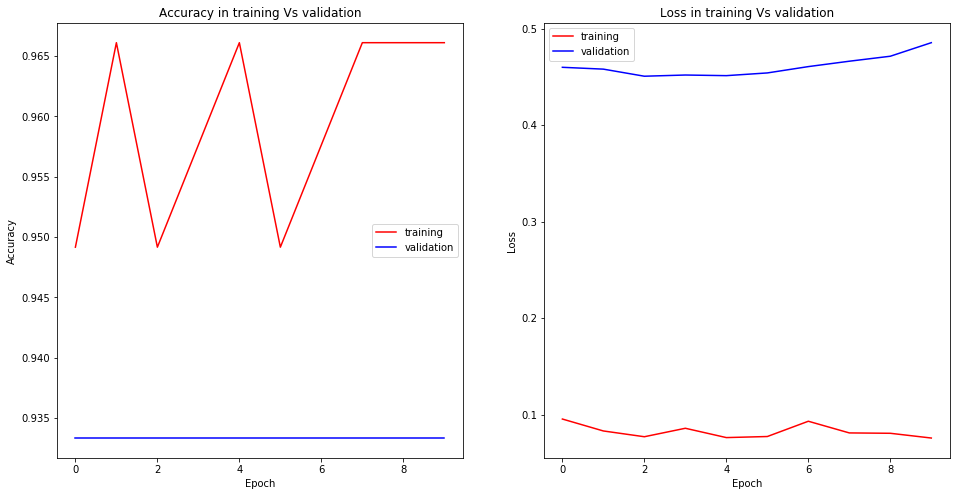

In [75]:
plot_history(history, 
             acc='prediction_acc', 
             val_acc='val_prediction_acc', 
             loss='prediction_loss', 
             val_loss='val_prediction_loss')

In [76]:
test_prediction = model.predict([X_test, X_test_c])
y_pred = np.where(test_prediction[0]>0.5, 1.0, 0.0)

In [77]:
from sklearn.metrics import accuracy_score

test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.2f}")

Test accuracy: 0.92


It seems that with the convolutional based model we get more accurate and with the additional benefit of a faster training. Hence, We will export the CNN based model for later usage in spark.

In [79]:
model.save("../../models/keras/tweet-lang-classification")